In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.applications import inception_v3
from keras import backend as K
K.set_learning_phase(0)

model=inception_v3.InceptionV3(weights='imagenet',include_top=False)

87916544/87910968 [==============================] - 162s 2us/step


In [30]:
layer_contributions={
    'mixed2':0.2,
    'mixed3':3.,
    'mixed4':2.,
    'mixed5':1.5,
}

In [32]:
layer_dict=dict([(layer.name,layer)for layer in model.layers])

loss=K.variable(0.)
print(loss)
for name in layer_contributions:
    coeff =layer_contributions[name]
    activation = layer_dict[name].output
    
    scaling =K.prod(K.cast(K.shape(activation),'float32'))
    loss+=coeff*K.sum(K.square(activation[:,2:-2,2:-2,:]))
    

<tf.Variable 'Variable_2:0' shape=() dtype=float32_ref>


In [33]:
dream =model.input
grads=K.gradients(loss,dream)[0]
grads/=K.maximum(K.mean(K.abs(grads)),1e-7)

In [34]:
outputs=[loss,grads]
fetch_loss_and_grads=K.function([dream],outputs)
def eval_loss_grads(x):
    outs=fetch_loss_and_grads([x])
    loss_value=outs[0]
    grad_value=outs[1]
    return loss_value,grad_value

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [35]:
import scipy
from keras.preprocessing import image
def resize_img(img,size):
    img=np.copy(img)
    factors=(1,
             float(size[0])/img.shape[1],
             float(size[1])/img.shape[2],
            1
            )
    
    return scipy.ndimage.zoom(img,factors,order=1)

def save_img(img,fname):
    pil_img=deprocess_image(np.copy(img))
    scipy.misc.imsave(fname,pil_img)
    
def preprocessing_img(image_path):
    img=image.load_img(image_path)
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=inception_v3.preprocess_input(img)
    return img
    # Util function to convert a tensor into a valid image.
def deprocess_image(x):
    if K.image_data_format()=='channels_first':
        x=x.reshape((3,x.shape[2],x.shape[3]))
        x=x.transpose((1,2,0))
    else:
        x=x.reshape((x.shape[1],x.shape[2],3))
    x/=2.
    x+=0.5
    x*=255.
    x=np.clip(x,0,255).astype('uint8')
    return x


In [42]:
import numpy as np

step=0.01
num_octave=3
octave_scale=1.4
iterations=20

max_loss=100000000.
base_image_path='E:/photo/747c9de640cda3f6.jpg'
img=preprocessing_img(base_image_path)

original_shape=img.shape[1:3]
successive_shapes=[original_shape]
print(successive_shapes)
for i in range(1,num_octave):
    shape=tuple([int(dim/(octave_scale**i))for dim in original_shape])

    successive_shapes.append(shape)
successive_shapes=successive_shapes[::-1]

original_img=np.copy(img)
shrunk_original_img=resize_img(img,successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape',shape)
    img=resize_img(img,shape)
    img=gradient_ascent(img,
                       iterations=iterations,
                       step=step,
                       max_loss=max_loss)
    upscaled_shrunck=resize_img(shrunk_original_img,shape)
    same_size_original=resize_img(original_img,shape)
    lost=same_size_original-upscaled_shrunck
    print(successive_shapes)
    img+=lost
    shrunk_original_img=resize_img(original_img,shape)
    save_img(img,fname='dream_at_scale'+str(shape)+'.png')
save_img(img,fname='final_dream.png')

[(865, 1193)]
Processing image shape (441, 608)
...Loss value at 0 : 1061174.9
...Loss value at 1 : 1386556.8
...Loss value at 2 : 1794933.4
...Loss value at 3 : 2298356.5
...Loss value at 4 : 2818950.2
...Loss value at 5 : 3340813.8
...Loss value at 6 : 3846982.5
...Loss value at 7 : 4330744.0
...Loss value at 8 : 4803111.5
...Loss value at 9 : 5296111.0
...Loss value at 10 : 5740808.5
...Loss value at 11 : 6161466.0
...Loss value at 12 : 6606184.5
...Loss value at 13 : 7010172.0
...Loss value at 14 : 7396231.0
...Loss value at 15 : 7765249.0
...Loss value at 16 : 8143575.0
...Loss value at 17 : 8531067.0
...Loss value at 18 : 8903996.0
...Loss value at 19 : 9259983.0
[(441, 608), (617, 852), (865, 1193)]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Processing image shape (617, 852)
...Loss value at 0 : 5201580.0
...Loss value at 1 : 7455458.5
...Loss value at 2 : 9198540.0
...Loss value at 3 : 10709167.0
...Loss value at 4 : 12080243.0
...Loss value at 5 : 13339412.0
...Loss value at 6 : 14509562.0
...Loss value at 7 : 15597172.0
...Loss value at 8 : 16654686.0
...Loss value at 9 : 17636916.0
...Loss value at 10 : 18592890.0
...Loss value at 11 : 19507608.0
...Loss value at 12 : 20385850.0
...Loss value at 13 : 21255544.0
...Loss value at 14 : 22086314.0
...Loss value at 15 : 22927132.0
...Loss value at 16 : 23753668.0
...Loss value at 17 : 24567284.0
...Loss value at 18 : 25378098.0
...Loss value at 19 : 26212588.0
[(441, 608), (617, 852), (865, 1193)]
Processing image shape (865, 1193)
...Loss value at 0 : 11920046.0
...Loss value at 1 : 17427624.0
...Loss value at 2 : 22056116.0
...Loss value at 3 : 26321224.0
...Loss value at 4 : 31263534.0
...Loss value at 5 : 36630430.0
...Loss value at 6 : 42624428.0
...Loss value at 7 : 5

Python tuple元组


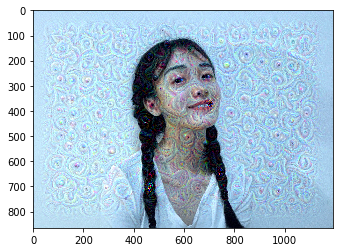

In [43]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()